<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/vgg_model_comprasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Thu Sep  2 08:32:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
baseline_model = models.vgg16(pretrained=True).to(device)  # 使用VGG16 网络预训练好的模型

epoch = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)
Loss_Baseline_Model = []

print('Baseline_Model Started Training')

for epoch in range(epoch):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()

        outputs = baseline_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Baseline_Model.append(running_loss)
            running_loss = 0.0
print('Baseline_Model Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Baseline_Model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 1.93668
[1,  4000] loss: 0.93066
[1,  6000] loss: 0.74496
[1,  8000] loss: 0.67558
[1, 10000] loss: 0.61479
[1, 12000] loss: 0.55669
[2,  2000] loss: 0.42881
[2,  4000] loss: 0.43054
[2,  6000] loss: 0.40097
[2,  8000] loss: 0.41425
[2, 10000] loss: 0.39758
[2, 12000] loss: 0.39665
[3,  2000] loss: 0.24236
[3,  4000] loss: 0.26208
[3,  6000] loss: 0.27866
[3,  8000] loss: 0.25718
[3, 10000] loss: 0.26525
[3, 12000] loss: 0.25672
[4,  2000] loss: 0.15993
[4,  4000] loss: 0.15877
[4,  6000] loss: 0.16649
[4,  8000] loss: 0.17313
[4, 10000] loss: 0.18394
[4, 12000] loss: 0.16673
[5,  2000] loss: 0.08895
[5,  4000] loss: 0.11720
[5,  6000] loss: 0.10794
[5,  8000] loss: 0.11633
[5, 10000] loss: 0.12255
[5, 12000] loss: 0.12281
[6,  2000] loss: 0.07071
[6,  4000] loss: 0.08317
[6,  6000] loss: 0.07700
[6,  8000] loss: 0.08529
[6, 10000] loss: 0.08706
[6, 12000] loss: 0.07792
[7,  2000] loss: 0.05614
[7,  4000] loss: 0.06401
[7,  6000] loss: 0.07383
[7,  8000] loss: 0.05558


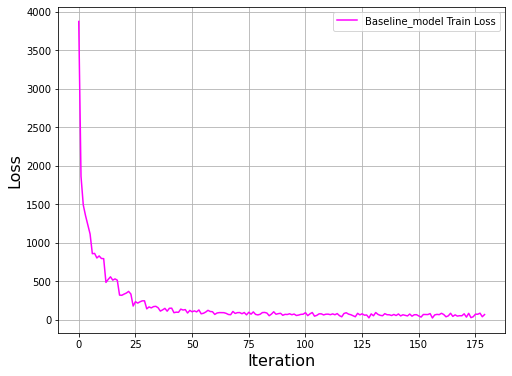

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
ax.plot(Loss_Baseline_Model, Color='magenta', label='Baseline_model Train Loss')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [ ]:
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
baseline_model.eval()

for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  outputs = baseline_model(images.to(device))
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 85.80 %
Class 1 accuracy: 93.60 %
Class 2 accuracy: 80.90 %
Class 3 accuracy: 76.60 %
Class 4 accuracy: 83.80 %
Class 5 accuracy: 82.00 %
Class 6 accuracy: 94.00 %
Class 7 accuracy: 89.40 %
Class 8 accuracy: 91.80 %
Class 9 accuracy: 93.80 %
accuracy: 87.17 %


In [ ]:
def softmax_temperature(logits, temperature):
    pro = F.softmax(logits / temperature, dim=-1)
    return pro;

In [ ]:
def mapping_onehot_vector(vector):
    return vector @ torch.LongTensor(range(0, vector.shape[1]))

In [ ]:
class LearnableLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, init_temperature: float):
        super(LearnableLookUpTable, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.temperature = nn.Parameter(torch.tensor(init_temperature, requires_grad=True))

    def forward(self, x):
        # if self.training:
          x = softmax_temperature(x, self.temperature)
          return x @ self.emb.weight
        # else:
        #   x = softmax_temperature(x, 0.00001)
        #   x = mapping_onehot_vector(x)
        #   return self.emb(x)

In [ ]:
class Learnable_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel, init_temperature):
    super(Learnable_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = LearnableLookUpTable(25088, 4096, init_temperature)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x)
    x = self.classifier(x)
    return x

In [ ]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
learnable_lut_model = Learnable_VGG_LookUpTable(pre_model, 1.).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(learnable_lut_model.parameters(), lr=learning_rate)
Loss_Learnable_Model = []
Temperature = []

print('Learnable_lut_model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = learnable_lut_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Learnable_Model.append(running_loss)
            running_loss = 0.0

            for parameter in learnable_lut_model.named_parameters():
              if parameter[0] == 'look_up_table.temperature':
                print('[%d, %5d] temperature: %.5f' %
                  (epoch + 1, i + 1, parameter[1].data.detach().cpu().numpy()))
                Temperature.append(parameter[1].data.detach().cpu().numpy())

print('Learnable_lut_model Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Learnable_lut_model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 3.17928
[1,  2000] temperature: 1.00090
[1,  4000] loss: 2.15733
[1,  4000] temperature: 1.00223
[1,  6000] loss: 1.74802
[1,  6000] temperature: 1.00311
[1,  8000] loss: 1.40108
[1,  8000] temperature: 1.00471
[1, 10000] loss: 1.20022
[1, 10000] temperature: 1.00534
[1, 12000] loss: 1.05757
[1, 12000] temperature: 1.00590
[2,  2000] loss: 0.82313
[2,  2000] temperature: 1.00606
[2,  4000] loss: 0.74209
[2,  4000] temperature: 1.00598
[2,  6000] loss: 0.67250
[2,  6000] temperature: 1.00641
[2,  8000] loss: 0.64583
[2,  8000] temperature: 1.00655
[2, 10000] loss: 0.59703
[2, 10000] temperature: 1.00690
[2, 12000] loss: 0.56011
[2, 12000] temperature: 1.00706
[3,  2000] loss: 0.41514
[3,  2000] temperature: 1.00667
[3,  4000] loss: 0.40990
[3,  4000] temperature: 1.00652
[3,  6000] loss: 0.39220
[3,  6000] temperature: 1.00640
[3,  8000] loss: 0.38335
[3,  8000] temperature: 1.00632
[3, 10000] loss: 0.41185
[3, 10000] temperature: 1.00643
[3, 12000] loss: 0.37784
[3, 12

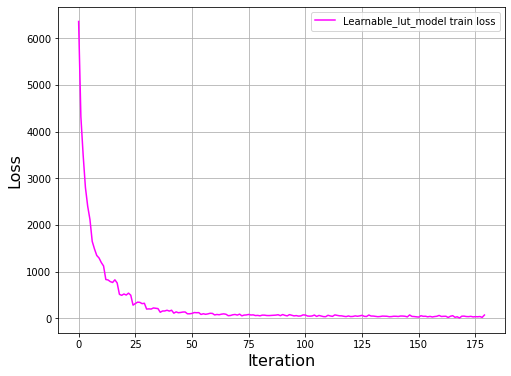

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
ax.plot(Loss_Learnable_Model, Color='magenta', label='Learnable_lut_model train loss')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

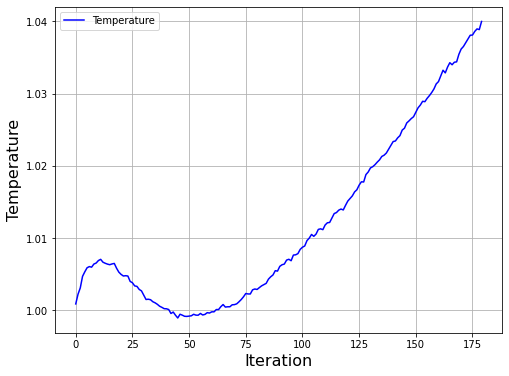

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
ax.plot(Temperature, Color='blue', label='Temperature')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Temperature", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [ ]:
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
learnable_lut_model.eval()

for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  outputs = learnable_lut_model(images.to(device))
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 90.40 %
Class 1 accuracy: 94.60 %
Class 2 accuracy: 80.80 %
Class 3 accuracy: 79.50 %
Class 4 accuracy: 91.20 %
Class 5 accuracy: 82.50 %
Class 6 accuracy: 87.40 %
Class 7 accuracy: 87.10 %
Class 8 accuracy: 91.50 %
Class 9 accuracy: 93.90 %
accuracy: 87.89 %


In [ ]:
class AnnealingLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super(AnnealingLookUpTable, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x, temperature):
        if self.training:
          x = softmax_temperature(x, temperature)
          return x @ self.emb.weight
        else:
          # x = softmax_temperature(x, 0.00001)
          # x = mapping_onehot_vector(x)
          # return self.emb(x)

          x = softmax_temperature(x, temperature)
          nozero = torch.nonzero(x);
          out = np.zeros((x.shape[0], self.embedding_dim))
          out = torch.tensor(out).to(device)
          # print(np.array(nozero).shape[1])
          for i in range(x.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          return out.float()

In [ ]:
class Annealing_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel):
    super(Annealing_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = AnnealingLookUpTable(25088, 4096)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x, temperature):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x, temperature)
    x = self.classifier(x)
    return x

In [ ]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, math.exp(-1.4 * math.pow(10, -5) * idx)), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loss_Annealing_Model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 3.10420
[1,  4000] loss: 2.34805
[1,  6000] loss: 2.12398
[1,  8000] loss: 1.76205
[1, 10000] loss: 1.49541
[1, 12000] loss: 1.23864
[2,  2000] loss: 1.06567
[2,  4000] loss: 1.02809
[2,  6000] loss: 0.95359
[2,  8000] loss: 0.83489
[2, 10000] loss: 0.73476
[2, 12000] loss: 0.66550
[3,  2000] loss: 0.51731
[3,  4000] loss: 0.49734
[3,  6000] loss: 0.47294
[3,  8000] loss: 0.45993
[3, 10000] loss: 0.48085
[3, 12000] loss: 0.44500
[4,  2000] loss: 0.30912
[4,  4000] loss: 0.29524
[4,  6000] loss: 0.30302
[4,  8000] loss: 0.30145
[4, 10000] loss: 0.31440
[4, 12000] loss: 0.29799
[5,  2000] loss: 0.17827
[5,  4000] loss: 0.19154
[5,  6000] loss: 0.20562
[5,  8000] loss: 0.20739
[5, 10000] loss: 0.19600
[5, 12000] loss: 0.18722
[6,  2000] loss: 0.11970
[6,  4000] loss: 0.11709
[6,  6000] loss: 0.11893
[6,  8000] loss: 0.13159
[6, 10000] loss: 0.12731
[6, 12000] loss: 0.12789
[7,  2000] loss: 0.07589
[7,  4000] loss: 0.08296
[7,  6000] loss: 0.09465
[7,  8000] loss: 0.07980


In [ ]:
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
Annealing_lut_model.eval()

for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  outputs = Annealing_lut_model(images.to(device), 0.0001)
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 86.20 %
Class 1 accuracy: 84.10 %
Class 2 accuracy: 83.20 %
Class 3 accuracy: 76.20 %
Class 4 accuracy: 89.60 %
Class 5 accuracy: 75.20 %
Class 6 accuracy: 86.70 %
Class 7 accuracy: 89.00 %
Class 8 accuracy: 88.60 %
Class 9 accuracy: 92.80 %
accuracy: 85.16 %


In [ ]:
print(idx)
print(math.exp(-1.4 * math.pow(10, -5) * idx))

In [3]:
# Loss_Baseline_Model = [3872.4723823554814, 1863.5793002019636, 1501.223158330802, 1349.2540111092385, 1221.8130096917157, 1118.8604160515824, 859.1576800966432, 859.8661447088098, 819.6694815727824, 827.1000121614488, 798.2041533824977, 808.4048638707463, 498.0559452059506, 527.3723640723008, 558.3351522767725, 526.0050897749522, 521.1613981830073, 520.7777481278794, 308.995667043178, 301.2820669818178, 336.91673734006577, 360.1487615352137, 359.5988904956185, 328.53010717166296, 179.61531050015392, 234.69278697661755, 220.69319845028116, 238.96496242420662, 231.45076282694504, 232.93256985726043, 139.0307325424412, 171.09906588262777, 160.53744012389538, 177.01450049418492, 171.83414549059944, 167.54262140477843, 119.0473997492023, 142.78874401193275, 140.93155763452728, 111.74711841836245, 138.90022822534632, 174.03522936781852, 97.02349838853645, 101.2056621288282, 108.33963276619366, 136.8385455312183, 118.43028946202854, 118.41986965166821, 73.5163950850706, 115.02205457964922, 91.50348705507238, 119.80242552370741, 107.13343405102194, 109.0910082612557, 74.33901712564789, 120.6939232646156, 86.95020424352555, 92.70516228477008, 106.7124025397303, 100.71564648983806, 71.7150446519288, 92.8872870723505, 86.63256498497988, 81.5237209491748, 103.00146288429349, 83.09606986221122, 85.25948916934121, 73.86067596473012, 79.03808763315368, 102.18404999074914, 91.42716348980068, 116.47785726175437, 68.41375367630152, 72.39254919790348, 81.00756056757008, 71.13493533454465, 116.27289914695004, 65.36616816252592, 74.95805117974577, 76.41879002485568, 68.59389631393041, 85.5210969196366, 74.2178501904765, 82.65740841028313, 78.63777634770949, 76.3299671442571, 71.79690761218612, 77.2477860079891, 85.94890044890931, 81.18688872279014, 88.60264125410002, 70.71979611234062, 77.41422285909461, 73.11868273872469, 64.26316343510287, 85.48847266865883, 48.033256053277825, 68.8297884905351, 70.19767597626904, 70.26955642649907, 61.94714754030673, 83.71710877128146, 46.837729820042135, 60.80186155515577, 81.47671269143744, 62.15326320772972, 75.67200374030517, 64.25088928063101, 49.05531776589211, 74.50230784857231, 111.5000207416035, 38.05799335901368, 82.29446302157078, 78.14539487217668, 38.560025261562394, 67.89774180858927, 73.75660533415126, 51.43208889767011, 105.70880510860391, 57.26538708586227, 72.58460400227199, 80.55776796775183, 45.673699569412115, 71.16718857076746, 73.66752777449386, 65.60420585310555, 61.228733935776766, 88.31739258108242, 55.88725032705219, 53.92037847424534, 100.48639461082166, 52.348766497907924, 50.63496010933789, 64.97323900253372, 63.625485928795015, 84.10255521979805, 75.63185398070425, 77.61983518585345, 56.132284707157176, 57.880874650302346, 91.22726258797564, 33.74433204822284, 53.28653791773909, 52.28676061980773, 58.88773025918036, 55.66815090888062, 62.69080931682161, 74.16834447087987, 65.75812045618105, 67.95539466688797, 72.76688934538996, 56.12244327387029, 91.9202623781264, 85.65937123884827, 53.307323940468684, 63.6229596697874, 40.39740958167532, 80.01023471952533, 37.78564058132689, 78.21692691462815, 74.82348729854468, 40.94175500150646, 67.85877886746286, 34.610651907377935, 57.474017339509906, 77.34275181206267, 80.36154955952887, 53.94306080083566, 43.62253291878008, 63.98891109764693, 46.91025066342119, 62.330327706064466, 91.10551972327882, 66.35640866559999, 59.502002995624984, 52.99414607845551, 54.474197417679804, 46.02516831444183, 68.90880281632244, 65.77219594388546]
# Loss_Learnable_Model = [6212.137823939323, 4689.819548845291, 3835.760307788849, 3095.6531695127487, 2816.142440855503, 2574.7640249729156, 2297.180137991905, 2139.2169994413853, 2030.0441165566444, 1690.7630194425583, 1361.949716359377, 1292.7211251929402, 973.9023675331846, 975.6482531530783, 886.8227000329643, 939.5573817854747, 899.8487724782899, 858.8820755546913, 595.1703743245453, 624.4764438553248, 607.0883182948455, 588.2957721748389, 613.2360910349526, 605.9834671209101, 388.4097411748953, 407.37585869571194, 396.7979876487516, 389.64830555883236, 396.1113784094341, 394.3182215037523, 252.3591319003026, 267.4459488361899, 260.20063259539893, 284.0571354191634, 260.405598602767, 269.4163694730669, 160.7044197198702, 195.61299871242954, 191.46402162931918, 185.99093928234652, 179.13650948031864, 202.78649691299506, 109.70876720805973, 118.22431438843341, 151.27373009996518, 154.23891497226214, 137.5814643246631, 148.10607673851155, 105.06861610508349, 111.35470533634361, 125.58070031628449, 108.96840128941403, 123.03943383180376, 110.09879583541169, 95.42422875816919, 94.26651898704586, 105.07484752259552, 105.29430524571217, 109.46808840766062, 105.52857031385247, 95.1211090495508, 87.10136637810137, 81.15566907352513, 88.30897044225912, 92.00560976927954, 79.06364886554275, 72.87489205952716, 84.17281498642433, 84.89272049971078, 87.85826579639206, 92.3493723241545, 62.88610617472159, 53.81888038313876, 65.67493129069464, 76.38767384195233, 62.593316651053044, 81.90145488356484, 82.97710066113677, 59.84626862111463, 69.63320644265218, 48.21090318258871, 62.85314696564046, 89.05767118638471, 64.64446237797387, 45.78992615851075, 54.48879579699458, 60.4778020250439, 59.55159997983844, 71.35787641681304, 55.00673307860822, 57.1110934396188, 56.55424746946767, 52.71226132043239, 50.51277263482848, 49.193842625195785, 71.20184890251079, 40.52230848822151, 39.26277550947154, 66.89093888786225, 46.72631725759691, 42.51123091218835, 57.96290877966368, 42.218622467466446, 69.438961181754, 35.0262669249168, 45.81295279933511, 55.05740551645599, 47.08754278184797, 50.36186095196342, 61.26293144835614, 35.47902050779794, 43.20892465110043, 58.58281717359756, 45.01439590518328, 69.24433032744935, 37.79203931229202, 51.89790377389874, 47.76425655785906, 53.20411532130366, 53.69322464346675, 22.920748066101048, 35.26002254648773, 57.522474578564754, 35.10397905402275, 63.99781816286833, 37.98736877688238, 43.732989175573486, 43.448189963089206, 54.336775284007985, 41.79671146354167, 45.21930541816472, 33.40986497355907, 35.99930419522471, 41.58883331481143, 38.385960624099745, 52.32445651491808, 54.324965394975756, 39.0148264122425, 30.171574600751512, 41.9790742561806, 33.9996152667441, 26.412510816573352, 55.86597015974281, 44.46255237818826, 32.68804222793181, 52.97323773818024, 33.045870668412334, 39.01034161493787, 53.95942491932061, 43.955829118745704, 31.203081911408802, 21.38146838578358, 49.68021484688384, 43.468584698289774, 40.31996255117724, 40.11141857771403, 28.69335275445714, 36.59136573031253, 39.29623337180672, 35.056964611190786, 55.42968761897522, 18.39460391637514, 20.52764449063534, 42.98221463087579, 48.16276641117669, 20.124605049740296, 47.31239208553568, 19.624705581052865, 42.062905458794056, 42.67677137083652, 31.325026984392945, 40.344050626845224, 41.8741307968726, 17.934331924844138, 43.67056530231875, 21.866402292821085, 34.88604005540979, 45.487474598246, 42.008949378079954, 28.6492924542163]
# Loss_Annealing_Model = [6231.092164993286, 4690.212652802467, 4687.280135750771, 4100.131859660149, 3260.990114212036, 2797.9389079511166, 2242.2153088748455, 2054.326329395175, 1902.2268817424774, 1651.0858060084283, 1483.9742424245924, 1326.0508961277083, 1008.449092803523, 954.4897480243817, 913.322356577497, 895.9502169264015, 870.6353339552879, 844.6116244744044, 552.3058530569542, 567.9375108380336, 545.5687112492742, 552.76754801278, 585.0532651745016, 576.6419852110557, 312.03054498974234, 342.70576283481205, 351.26043109592865, 340.555844418559, 346.91504351084586, 351.47508456831565, 192.43178626976442, 212.68704608397093, 220.97180833879975, 219.21986336936243, 227.65297506190836, 241.9382052024448, 122.19085505481053, 141.81727216899162, 136.53786210238468, 164.95525408505637, 164.67899104962999, 169.54875132197049, 100.14821060928807, 122.93376173271099, 108.93345714772295, 120.32376036408095, 146.91766293521505, 121.38307090081071, 84.03621486754855, 105.16295000497485, 106.42995667358628, 123.04830170256173, 87.72030229902884, 96.14520392541817, 60.20757265454449, 77.46870327835131, 88.35191826517257, 121.65930177731207, 78.17798579139344, 97.23157603420987, 62.5323615134148, 90.99251723841735, 91.23599135463155, 104.7271377016732, 78.0932487523387, 100.64331095875968, 78.29763677970186, 71.62549236315317, 85.00378897006522, 115.39051939186174, 74.74071970650039, 89.47360172781919, 71.90477365828883, 74.09583036621189, 75.33846009565968, 77.4318645712483, 72.07530027376743, 80.82826714703697, 60.59188737144723, 74.65339221247632, 68.18054924989156, 93.664784394643, 86.66175408853087, 68.13191204388022, 53.96841225976459, 75.34278068234198, 71.30496257489176, 79.80423589825477, 77.74051723857065, 107.97372066470052, 54.20786864580441, 69.6837667351756, 66.55868085013026, 90.38735349702256, 98.36672773450118, 87.65911394064278, 81.70094158377287, 57.859405776099265, 73.4560215423353, 75.29086695590559, 56.202124666655436, 94.10987959777412, 73.60529915317966, 70.99814849329505, 86.58664091928222, 93.00180874876241, 88.0331976942307, 87.07355485171229, 76.03164920909057, 66.67554526828735, 110.78660140763168, 90.16586836248098, 79.00909572859382, 89.25493579963404, 81.30645393086161, 76.35364136417411, 76.62280708688377, 86.35228715305493, 86.9142921979601, 73.05877618660634, 70.96011568990343, 80.73401290960646, 77.30651834688979, 98.83511892082788, 83.79546108726026, 76.46075602175915, 77.3393502383442, 67.87405310929898, 93.32102540881488, 74.10170905415998, 100.89563251015898, 98.85616939654483, 84.29354021706331, 99.57316583661668, 85.75901075950969, 81.58517681305602, 86.77166991368995, 80.10382615208982, 100.10468119212237, 97.22514132486322, 81.36347216836111, 65.81457608847631, 95.59881529698396, 129.63253601994984, 86.80205378886967, 76.70745454192001, 81.01889426447997, 115.42929298023591, 114.23281280201263, 102.72647781715568, 70.21961218379874, 136.6116321048321, 101.93232905594141, 104.42025103644846, 97.00132614474205, 148.7955919936794, 99.0442544215548, 86.18047041375394, 109.13569476468183, 88.25236125586162, 123.8237065694666, 114.44588558723626, 123.97805382693696, 80.07164347153775, 107.8556060194278, 104.7514592457992, 156.34313712380572, 83.16749953178805, 95.9877470912179, 115.46795574127464, 139.1147727615462, 113.89938317714405, 153.9400667953305, 125.5068986740298, 132.9425539704389, 103.81769484770302, 165.49791783306136, 147.7970235398243, 138.80470542560215, 160.01104389246757]

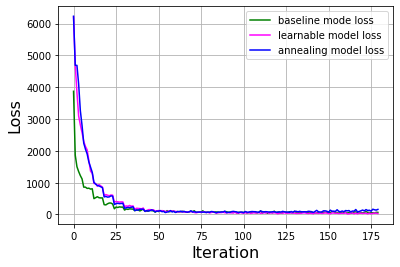

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Loss_Baseline_Model, Color='green', label='baseline mode loss')
ax.plot(Loss_Learnable_Model, Color='magenta', label='learnable model loss')
ax.plot(Loss_Annealing_Model, Color='blue', label='annealing model loss')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [ ]:
print(Loss_Learnable_Model)

[6212.137823939323, 4689.819548845291, 3835.760307788849, 3095.6531695127487, 2816.142440855503, 2574.7640249729156, 2297.180137991905, 2139.2169994413853, 2030.0441165566444, 1690.7630194425583, 1361.949716359377, 1292.7211251929402, 973.9023675331846, 975.6482531530783, 886.8227000329643, 939.5573817854747, 899.8487724782899, 858.8820755546913, 595.1703743245453, 624.4764438553248, 607.0883182948455, 588.2957721748389, 613.2360910349526, 605.9834671209101, 388.4097411748953, 407.37585869571194, 396.7979876487516, 389.64830555883236, 396.1113784094341, 394.3182215037523, 252.3591319003026, 267.4459488361899, 260.20063259539893, 284.0571354191634, 260.405598602767, 269.4163694730669, 160.7044197198702, 195.61299871242954, 191.46402162931918, 185.99093928234652, 179.13650948031864, 202.78649691299506, 109.70876720805973, 118.22431438843341, 151.27373009996518, 154.23891497226214, 137.5814643246631, 148.10607673851155, 105.06861610508349, 111.35470533634361, 125.58070031628449, 108.96840

In [ ]:
print(Loss_Annealing_Model)

[6231.092164993286, 4690.212652802467, 4687.280135750771, 4100.131859660149, 3260.990114212036, 2797.9389079511166, 2242.2153088748455, 2054.326329395175, 1902.2268817424774, 1651.0858060084283, 1483.9742424245924, 1326.0508961277083, 1008.449092803523, 954.4897480243817, 913.322356577497, 895.9502169264015, 870.6353339552879, 844.6116244744044, 552.3058530569542, 567.9375108380336, 545.5687112492742, 552.76754801278, 585.0532651745016, 576.6419852110557, 312.03054498974234, 342.70576283481205, 351.26043109592865, 340.555844418559, 346.91504351084586, 351.47508456831565, 192.43178626976442, 212.68704608397093, 220.97180833879975, 219.21986336936243, 227.65297506190836, 241.9382052024448, 122.19085505481053, 141.81727216899162, 136.53786210238468, 164.95525408505637, 164.67899104962999, 169.54875132197049, 100.14821060928807, 122.93376173271099, 108.93345714772295, 120.32376036408095, 146.91766293521505, 121.38307090081071, 84.03621486754855, 105.16295000497485, 106.42995667358628, 123.